In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from get_data import get_assets, get_positional_data

get_assets()


This process will pip install Kaggle and download data through Kaggle API.

Please confirm that you've downloaded Kaggle JSON credentials into directory



401 - Unauthorized
Data Successfully Downloaded


In [37]:
week_data = pd.read_csv('Kaggle-Data-Files/week1.csv')

In [38]:
week_data.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH


In [39]:
# Check dataframe. There are some null values in nflId.
week_data.describe()

,x,y,s,a,dis,o,dir,nflId,jerseyNumber,frameId,gameId,playId
count,986022.000000,986022.000000,986022.000000,986022.000000,986022.000000,919109.000000,919109.000000,9.191090e+05,919109.000000,986022.000000,9.860220e+05,986022.000000
mean,58.975056,26.795439,3.187303,2.012526,0.323366,179.545196,181.238304,2.366598e+06,37.763714,35.450674,2.018091e+09,2268.306314
std,24.935961,11.204589,2.843484,1.689410,0.307017,100.706586,102.965112,6.193264e+05,24.977470,23.654286,9.381592e+01,1280.426499
min,-5.980000,-11.740000,0.000000,0.000000,0.000000,0.000000,0.000000,3.060000e+02,1.000000,1.000000,2.018091e+09,58.000000
25%,39.980000,19.000000,0.850000,0.740000,0.090000,89.880000,91.520000,2.533040e+06,20.000000,17.000000,2.018091e+09,1199.000000
50%,59.100000,26.830000,2.790000,1.750000,0.280000,177.430000,181.410000,2.552255e+06,29.000000,33.000000,2.018091e+09,2297.000000
75%,78.190000,34.710000,4.960000,2.940000,0.500000,269.840000,271.350000,2.556480e+06,53.000000,50.000000,2.018091e+09,3315.000000
max,128.380000,62.750000,27.370000,58.330000,7.120000,360.000000,360.000000,2.561485e+06,99.000000,172.000000,2.018091e+09,5511.000000


In [40]:
# The null nflId column values are from the movements of the football.
# This will be filtered later in the notebook.
week_data[week_data['nflId'].isnull()]['displayName'].unique()

array(['Football'], dtype=object)

In [41]:
football_data = week_data[week_data['nflId'].isnull()]
week_non_foot = week_data[week_data['nflId'].notnull()]

In [42]:
# Read play data.
play_data = pd.read_csv('Kaggle-Data-Files/plays.csv')

In [43]:
# Check for null values. Some yardline numbers are null.
play_data.describe()

,gameId,playId,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,offensePlayResult,playResult,epa
count,1.923900e+04,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19177.000000,18606.000000,18600.000000,18600.000000,18600.000000,19239.000000,19239.000000,19239.000000
mean,2.018107e+09,2176.217319,2.591039,1.920318,8.923905,29.860232,6.036189,4.216543,10.758333,12.465484,59.905753,6.279380,6.469047,0.020725
std,1.148060e+04,1240.919041,1.123155,0.848819,3.974216,12.444118,1.015547,0.897862,9.798115,10.552753,23.641588,10.184296,10.566605,1.580748
min,2.018091e+09,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,11.000000,-19.000000,-78.000000,-11.935951
25%,2.018100e+09,1125.000000,2.000000,1.000000,6.000000,21.500000,6.000000,4.000000,3.000000,3.000000,40.000000,0.000000,0.000000,-0.745327
50%,2.018110e+09,2166.000000,3.000000,2.000000,10.000000,30.000000,6.000000,4.000000,9.000000,10.000000,60.000000,4.000000,4.000000,-0.190540
75%,2.018120e+09,3203.500000,4.000000,3.000000,10.000000,40.000000,7.000000,5.000000,17.000000,20.000000,80.000000,10.000000,11.000000,0.976822
max,2.018123e+09,5661.000000,5.000000,4.000000,41.000000,50.000000,11.000000,10.000000,51.000000,54.000000,109.000000,97.000000,97.000000,8.629316


In [44]:
# Filter to include non-null yardline numbers.
play_data = play_data[play_data['absoluteYardlineNumber'].notnull()]

In [45]:
play_data.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa',
       'isDefensivePI'],
      dtype='object')

In [46]:
# Merge movement and play-by-play datasets.
week_play = week_non_foot.merge(play_data, on=['gameId', 'playId'])

In [47]:
week_play.shape[0]

879420

In [48]:
# Convert time to datetime format.
week_play['time'] = pd.to_datetime(week_play['time'], format='%Y-%m-%dT%H:%M:%S')

In [49]:
# Extract the time elapsed in the play. Labeled as "time_acc_s". May take a while for full dataset.
week_play['time_diff'] = week_play.groupby(['playId', 'gameId', 'displayName'])['time'].diff()
week_play['time_diff'][week_play['time_diff'].isnull()] = pd.Timedelta(0)
week_play['time_acc_s'] = week_play.groupby(['playId', 'gameId', 'displayName'])['time_diff'].transform(
    lambda x: x.map(lambda x: x.microseconds).cumsum()).div(1e6)

/var/folders/6v/8jcf0jcn7_vfm2q2r4tz44gh0000gn/T/ipykernel_2146/2374433625.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_play['time_diff'][week_play['time_diff'].isnull()] = pd.Timedelta(0)


In [50]:
# Load game data.
games = pd.read_csv('Kaggle-Data-Files/games.csv')

In [51]:
# Merge play-by-play and movement data with game data.
week_play_games = week_play.merge(games, on='gameId')

In [52]:
# Check values of team.
week_play_games['team'].unique()

array(['away', 'home'], dtype=object)

In [53]:
# Find which teams in the dataframe are offensive vs. defensive.
week_play_games['off'] = np.where(week_play_games['position'].isin(['QB', 'HB', 'FB', 'WR', 'TE', 'C', 'OG', 'OT', 'RB']),
                                            True, False)

In [54]:
# Check position counts for defense. All positions are correctly labelled.
week_play_games[~week_play_games['off']]['position'].value_counts()

CB     180986
OLB     79913
FS      65032
SS      58117
ILB     50239
MLB     25355
LB      20039
DB      12098
S        3307
DL        592
DE        116
NT         48
Name: position, dtype: int64

In [55]:
# Check position counts for offense. All positions are correctly labelled.
week_play_games[week_play_games['off']]['position'].value_counts()

WR    172461
TE     79104
QB     64109
RB     63106
FB      2746
HB      2052
Name: position, dtype: int64

In [56]:
# Extract starting x and y position.
week_play_games['x_starting'] = week_play_games.groupby(['gameId', 'playId', 'nflId'])['x'].transform(lambda x: x.iloc[0])
week_play_games['y_starting'] = week_play_games.groupby(['gameId', 'playId', 'nflId'])['y'].transform(lambda x: x.iloc[0])

In [57]:
# Subtract 10 from yardline to get relative to left endzone.
week_play_games['yardline_100'] = week_play_games['absoluteYardlineNumber'].sub(10)

In [58]:
# Extract data for offense, including yardline numbers. Used to find the yardline for the first down.
week_off = week_play_games[week_play_games['off']].groupby(['gameId', 'playId'])[[
    'x_starting', 'yardline_100', 'absoluteYardlineNumber', 'yardsToGo']].first().reset_index()
week_off['yardline_first'] = np.where(week_off['x_starting'].gt(week_off['absoluteYardlineNumber']),
         week_off['yardline_100'].sub(week_off['yardsToGo']),
         week_off['yardline_100'].add(week_off['yardsToGo']))

In [59]:
# No null values in the dataframe, and  the yardline ranges are all reasonable.
week_off.describe()

,gameId,playId,x_starting,yardline_100,absoluteYardlineNumber,yardsToGo,yardline_first
count,9.900000e+02,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,2.018091e+09,2245.342424,59.273556,49.157576,59.157576,9.045455,48.807071
std,9.576537e+01,1281.510067,24.797976,24.163486,24.163486,4.186134,24.421065
min,2.018091e+09,58.000000,5.790000,1.000000,11.000000,1.000000,0.000000
25%,2.018091e+09,1147.250000,36.435000,28.250000,38.250000,7.000000,34.000000
50%,2.018091e+09,2262.500000,58.275000,48.000000,58.000000,10.000000,49.000000
75%,2.018091e+09,3297.750000,81.247500,70.000000,80.000000,10.000000,65.000000
max,2.018091e+09,5511.000000,110.980000,99.000000,109.000000,30.000000,100.000000


In [60]:
# Merge main dataframe with dataframe containing the first down yardline.
# Then extract which side offense is on.
week_first = week_play_games.merge(week_off[['gameId', 'playId', 'yardline_first']].drop_duplicates(), on=['gameId', 'playId'])
week_first['off_pos'] = np.where(week_first['yardline_first'].gt(week_first['yardline_100']),
                                 'left', 'right')

In [61]:
# There is a roughly even split, which looks good.
week_first['off_pos'].value_counts()

right    454305
left     425115
Name: off_pos, dtype: int64

In [62]:
# Adjust starting y coordinate because the perspective would change depending on the side.
week_first['y_starting_dir'] = np.where(week_first['off_pos'] == 'right', week_first['y_starting'].rsub(53.3), week_first['y_starting'])

<AxesSubplot:xlabel='y_starting', ylabel='Count'>

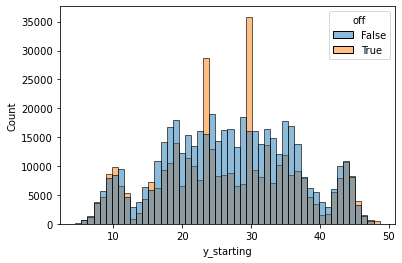

In [63]:
# Show distribution of starting y without adjustment. The values match up fairly well.
sns.histplot(data=week_first, x='y_starting', bins=50, hue='off')

<AxesSubplot:xlabel='y_starting_dir', ylabel='Count'>

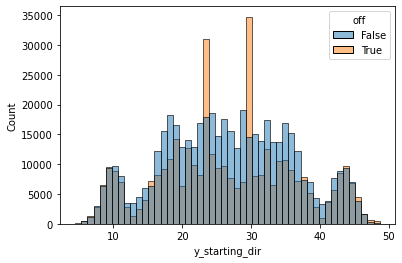

In [64]:
# The positions match up slightly better although the distributions are fairly symmetrical.
sns.histplot(data=week_first, x='y_starting_dir', bins=50, hue='off')

In [132]:
# Find starting position of qb and convert to float.
week_first['y_starting_qb'] = week_first.groupby(['gameId', 'playId']).apply(lambda x: np.repeat(53.3/2, x.shape[0])
    if x[x['position'] == 'QB'].shape[0] == 0 else np.repeat(x[x['position'] == 'QB']['y_starting_dir'].iloc[0], x.shape[0])).explode().values
week_first['y_starting_qb'] = week_first['y_starting_qb'].astype(float)

In [133]:
# Find side of qb that player is lined up on.
week_first['qb_side'] = np.where(week_first['y_starting_dir'].gt(week_first['y_starting_qb']), 'R', 'L')

In [211]:
# Find the starting position of each player relative to the qb.
week_first['y_starting_qb_dir'] = week_first['y_starting_dir'].sub(week_first['y_starting_qb'])

In [213]:
def find_rank(df, col, reverse=False):
    """
    Find the ranking of a series based on values.
    :param df: Dataframe for ranking; pd.DataFrame
    :param col: Column from dataframe to rank; str
    :param reverse: Flag of whether to reverse rank direction; bool
    :return: Array with rankings; np.array
    """
    # Extract series and use arsort to find rankings.
    ser = df[col]
    temp = np.argsort(ser)

    # Reverse direction based on flag.
    if reverse:
        temp = temp[::-1]

    # Fill ranking array.
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(ser.shape[0])
    return ranks

In [214]:
# Find the order of positions based on offensive direction.
# First, group and extract first value of the y starting position and direction.
pos_start = (week_first
 .groupby(['gameId', 'playId', 'position', 'nflId'])
 [['y_starting_dir', 'off_pos', 'qb_side']].first()
 .reset_index())

# Next, group and extract ranking of positions based on whether team is home or away
# and the starting position.
pos_order = (pos_start.groupby(['gameId', 'playId', 'position'])
             .apply(lambda x: np.where(x['qb_side'] == 'R', find_rank(x, 'y_starting_dir'),
                                       find_rank(x, 'y_starting_dir', reverse=True)))
             .explode()
             .reset_index()
             )

# Add column with the position order to the df with indexed starting position.
pos_start['pos_order'] = pos_order[0]

In [215]:
# Concatenate position and position order to create unique position identifier.
pos_start['pos_num'] = pos_start.apply(lambda x: x['position'] + x['qb_side'] + str(x['pos_order']), axis=1)

In [216]:
# Merge full dataframe with position number dataframe.
week_pos = week_first.merge(pos_start[['gameId', 'playId', 'nflId', 'pos_num', 'pos_order']], on=['gameId', 'playId', 'nflId'])

In [217]:
# Use regex to extract personnel from personnel column, and concatenate with main dataframe.
week_pos_pers = pd.concat([week_pos, week_pos['personnelD'].str.extract(
    '(?P<DL>\d+) DL, (?P<LB>\d+) LB, (?P<DB>\d+) DB')], axis=1)

In [218]:
# Find the position of each player relative to the line of scrimmage.
week_pos_pers['x_behind_line'] = np.where(week_pos_pers['off_pos'] == 'right',
                                     week_pos_pers['absoluteYardlineNumber'].sub(week_pos_pers['x']),
                                     week_pos_pers['x'].sub(week_pos_pers['absoluteYardlineNumber']))

<AxesSubplot:xlabel='x_behind_line', ylabel='Count'>

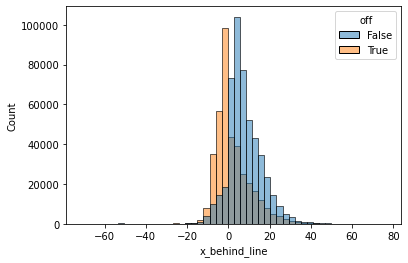

In [219]:
# Examine the x_behind_line column. The distributions seem to make sense,
# as the distribution of the offensive position has a lower mean than the defensive position.
sns.histplot(data=week_pos_pers, x='x_behind_line', bins=50, hue='off')

In [220]:
# Extract the yardline for first down and line of scrimmage based on the
# direction that the teams are facing.
week_pos_pers['yardline_first_dir'] = np.where(week_pos_pers['off_pos'] == 'right',
                                          week_pos_pers['yardline_first'],
                                          week_pos_pers['yardline_first'].rsub(100))
week_pos_pers['yardline_100_dir'] = np.where(week_pos_pers['off_pos'] == 'right',
                                        week_pos_pers['yardline_100'],
                                        week_pos_pers['yardline_100'].rsub(100))

In [221]:
# Distribution of first yardline looks good. Range is within expected.
week_pos_pers['yardline_first_dir'].describe()

count    879420.000000
mean         43.631600
std          23.017777
min           0.000000
25%          26.000000
50%          48.000000
75%          65.000000
max          89.000000
Name: yardline_first_dir, dtype: float64

In [222]:
# Distribution of line of scrimmage also looks reasonable.
week_pos_pers['yardline_100_dir'].describe()

count    879420.000000
mean         52.764304
std          23.657820
min           1.000000
25%          36.000000
50%          57.000000
75%          73.000000
max          99.000000
Name: yardline_100_dir, dtype: float64

In [223]:
# Check that all first downs are labelled as closer to touchdown than line of scrimmage. Looks good.
week_pos_pers['yardline_first_dir'].lt(week_pos_pers['yardline_100_dir']).value_counts()

True    879420
dtype: int64

In [224]:
# Add flag if a player has gone at least 1 yard past the line of scrimmage.
week_pos_pers['exceeded_1yd'] = week_pos_pers.groupby(['gameId', 'playId', 'nflId'])['x_behind_line'].transform(lambda x: x.max() > 1)

In [225]:
# Use whether player is on offense, whether the player is a QB or WR, and whether a player has
# moved 1 yard beyond the line of scrimmage to determine if the player is a receiver.
week_pos_pers['receiver'] = (week_pos_pers['off'] & (week_pos_pers['position'] != 'QB') &
                            (week_pos_pers['exceeded_1yd'] | (week_pos_pers['position'] == 'WR')))

In [226]:
# Check positions that are labelled as receivers. Everything looks good.
week_pos_pers[week_pos_pers['receiver']]['position'].value_counts()

WR    172461
TE     68352
RB     41518
FB      1842
HB      1418
Name: position, dtype: int64

In [227]:
# Check value counts of players labelled receivers for offense.
# Looks reasonable given positions tracked.
week_pos_pers[week_pos_pers['off']]['receiver'].value_counts()

True     285591
False     97987
Name: receiver, dtype: int64

In [228]:
# Save offensive and defensive numbered position lists.
off_pos = week_pos_pers[week_pos_pers['off']]['pos_num'].unique()
def_pos = week_pos_pers[~week_pos_pers['off']]['pos_num'].unique()

In [229]:
# Adjust y to match direction of offense.
week_pos_pers['y_dir'] = np.where(week_pos_pers['off_pos'] == 'right', week_pos_pers['y'].rsub(53.3), week_pos_pers['y'])

In [230]:
# Define y coordinates as relative to QB.
week_pos_pers['y_dir_qb'] = week_pos_pers['y_dir'].sub(week_pos_pers['y_starting_qb'])

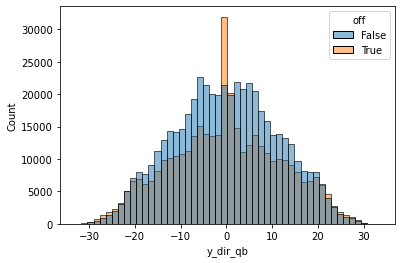

In [231]:
# The distribution looks centered around 0, as would be expected given that the QB lines up in the center.
sns.histplot(data=week_pos_pers, x='y_dir_qb', bins=50, hue='off')
plt.savefig('y_qb_dist.png')

In [232]:
# Find time that pass was thrown and merge with main df.
pass_made = football_data[football_data['event'] == 'pass_forward'][['gameId', 'playId', 'time']].rename({'time': 'time_pass'}, axis=1)
week_pos_pass = week_pos_pers.merge(pass_made, on=['gameId', 'playId'], how='left')

In [233]:
# Find whether part of play was before pass.
week_pos_pass['before_pass'] = week_pos_pass['time'].lt(week_pos_pass['time_pass'])

In [234]:
# Filter to include only part of play before pass.
week_pos_before_pass = week_pos_pass[week_pos_pass['before_pass']]

In [235]:
# Next, determine minimum distances between each defensive player and receiver and qb.
# Separate defensive and receiver dataframes.
week_rec = week_pos_before_pass[week_pos_pers['receiver']]
week_def = week_pos_before_pass[~week_pos_pers['off']]

# Merge defensive with receiver dataframes on game, play, and time.
week_def_rec = week_def.merge(week_rec[['gameId', 'playId', 'time_acc_s', 'x_behind_line', 'y_dir_qb']],
               on=['gameId', 'playId', 'time_acc_s'],
               suffixes=['_def', '_rec'])


# Find distance between each defensive player and each receiver.
week_def_rec['dist'] = np.linalg.norm(week_def_rec[['x_behind_line_def', 'y_dir_qb_def']].values -
                                               week_def_rec[['x_behind_line_rec', 'y_dir_qb_rec']].values, axis=1)

# Group dataframe to obtain minimum distance.
min_rec_dist = week_def_rec.groupby(['gameId', 'playId', 'time_acc_s', 'pos_num'])['dist'].min()
min_rec_dist.name = 'min_dist_rec'

# Separate QB dataframe
week_qb = week_pos_before_pass[week_pos_before_pass['position'] == 'QB']

# Merge defensive with QB dataframe.
week_def_qb = week_def.merge(week_qb[['gameId', 'playId', 'time_acc_s', 'x_behind_line', 'y_dir_qb']],
                              on=['gameId', 'playId', 'time_acc_s'],
                              suffixes=['_def', '_qb'])

# Find distance to the QB.
week_def_qb['dist'] = np.linalg.norm(week_def_qb[['x_behind_line_def', 'y_dir_qb_def']].values -
                                               week_def_qb[['x_behind_line_qb', 'y_dir_qb_qb']].values, axis=1)

# Group to form index and distance.
min_qb_dist = week_def_qb.groupby(['gameId', 'playId', 'time_acc_s', 'pos_num'])['dist'].min()
min_qb_dist.name = 'dist_qb'

# Concatenate about the same index and reset the index.
min_dist = pd.concat([min_rec_dist, min_qb_dist], axis=1).reset_index()

/var/folders/6v/8jcf0jcn7_vfm2q2r4tz44gh0000gn/T/ipykernel_2146/3609468992.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  week_rec = week_pos_before_pass[week_pos_pers['receiver']]
/var/folders/6v/8jcf0jcn7_vfm2q2r4tz44gh0000gn/T/ipykernel_2146/3609468992.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  week_def = week_pos_before_pass[~week_pos_pers['off']]


In [236]:
# Check that the distances are in a reasonable range. The max value is a bit high, but might be on long plays.
min_dist[['min_dist_rec', 'dist_qb']].describe()

,min_dist_rec,dist_qb
count,266161.000000,266161.000000
mean,7.186034,15.626214
std,4.964190,7.392183
min,0.063246,0.335410
25%,3.372506,9.699289
50%,6.266562,14.936800
75%,9.444448,20.431099
max,59.331578,76.602956


In [237]:
# Merge main dataframe with minimum distance dataframe.
week_pos_full = week_pos_before_pass.merge(min_dist, on=['gameId', 'playId', 'time_acc_s', 'pos_num'], how='left')

In [238]:
# Evaluate whether a receiver is closer than the qb.
week_pos_full['rec_closer'] = week_pos_full['min_dist_rec'].lt(week_pos_full['dist_qb'])

In [239]:
# Cut time accumulated into 10 deciles for each play in order to reduce the space. Can adjust number of cuts.
n_cuts = 11
time_cuts = week_pos_full[['gameId', 'playId', 'time_acc_s']].drop_duplicates().groupby(['gameId', 'playId']).agg(
    lambda x: np.nan if x.shape[0] < n_cuts else pd.cut(x, n_cuts, labels=range(1, n_cuts + 1))).explode('time_acc_s')
time_cuts_idx = week_pos_full[['gameId', 'playId', 'time_acc_s']].drop_duplicates().dropna()
time_cuts_idx = time_cuts_idx[time_cuts_idx.groupby(['gameId', 'playId'])['time_acc_s'].transform(lambda x: x.shape[0] >= n_cuts)]
time_cuts_idx['time_cut'] = time_cuts.values

In [240]:
# Merge dataframe with time quartiles to main dataframe.
week_full_time = week_pos_full.merge(time_cuts_idx, on=['gameId', 'playId', 'time_acc_s'])

<AxesSubplot:xlabel='pos_num', ylabel='time_cut'>

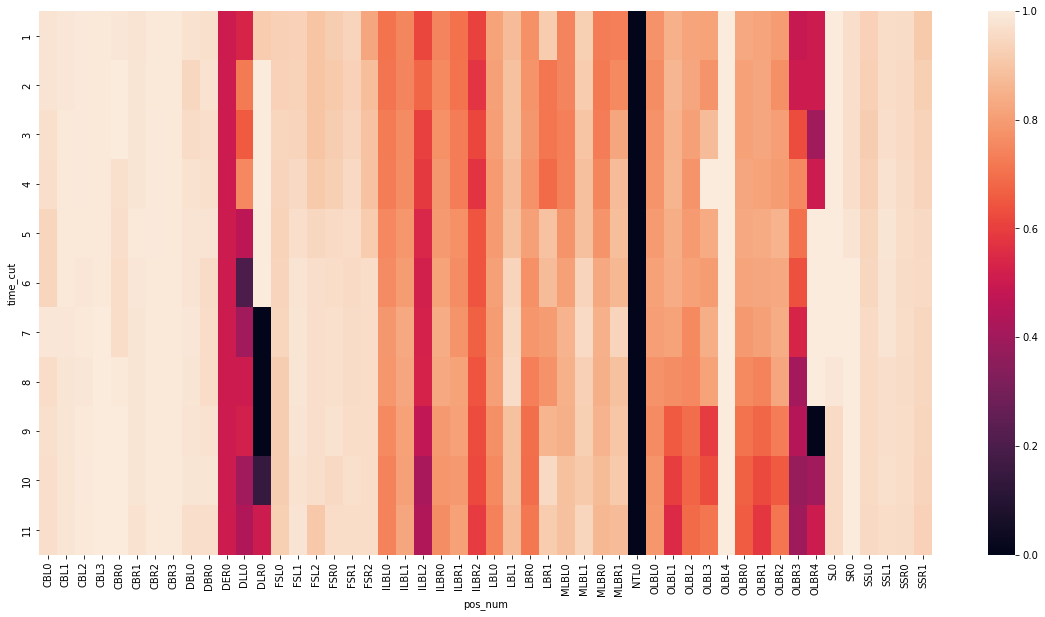

In [241]:
# Check average time
# Although all positions average closer to the receiver for each time decile,
# the positional distribution seem to make sense, with cornerbacks and safeties
# closest to the receivers.
week_rec_closer = week_full_time[~week_full_time['off']].groupby(['gameId', 'playId', 'time_cut', 'pos_num'])['rec_closer'].mean().reset_index()
rec_closer_def = week_rec_closer.groupby(['pos_num', 'time_cut'])['rec_closer'].mean().reset_index()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rec_closer_def.pivot_table(index='time_cut', columns='pos_num', values='rec_closer'), ax=ax)

In [242]:
# Aggregate columns based on game, play, numbered position, and time quartile.
def_full = week_full_time[~week_full_time['off'] & (week_full_time['position'] != 'TE')].groupby(['gameId', 'playId', 'pos_num', 'time_cut']).agg(
    {'x_starting': 'first', 'y_starting': 'first',
     'yardline_100_dir': 'first', 'yardline_first_dir': 'first',
     'defendersInTheBox': 'first',
     'numberOfPassRushers': 'first',
     'DL': 'first', 'LB': 'first', 'DB': 'first',
     'x_behind_line': 'mean', 'y_dir': 'mean', 'min_dist_rec': 'mean',
     'dist_qb': 'mean', 'rec_closer': 'mean'}
).reset_index()

In [243]:
# Pivot table based on play.
week_def_pivot = def_full.pivot_table(values=['rec_closer', 'dist_qb', 'min_dist_rec'],
                                           index=['gameId', 'playId', 'DL', 'LB', 'DB',
                                                  'yardline_first_dir', 'yardline_100_dir', 'defendersInTheBox',
                                                  'numberOfPassRushers'],
                                           columns=['pos_num', 'time_cut']).reset_index()

In [244]:
week_def_pivot.shape

(920, 1659)

In [245]:
# All of the index columns are full and do not have null values. Need to fill the null values in
# receiver columns with fill value.
week_def_pivot.describe()

gameId       playId yardline_first_dir yardline_100_dir  \
pos_num                                                                   
time_cut                                                                  
count     9.200000e+02   920.000000         920.000000       920.000000   
mean      2.018091e+09  2235.766304          43.289130        52.303261   
std       9.559843e+01  1279.198466          23.348546        23.993842   
min       2.018091e+09    58.000000           0.000000         1.000000   
25%       2.018091e+09  1134.750000          25.000000        35.000000   
50%       2.018091e+09  2273.500000          48.000000        57.000000   
75%       2.018091e+09  3280.000000          65.000000        73.000000   
max       2.018091e+09  5511.000000          89.000000        99.000000   

         defendersInTheBox numberOfPassRushers    dist_qb             \
pos_num                                              CBL0              
time_cut                                                1          2   
count           920.000000          920.000000  45.000000  44.000000   
mean              6.071739            4.141304  14.868333  14.901418   
std               0.945331            0.773353   5.192838   5.705134   
min               2.000000            0.000000   6.932732   7.116662   
25%               6.000000            4.000000  12.004168  11.630889   
50%               6.000000            4.000000  13.570766  13.275910   
75%               7.000000            4.000000  17.337086  16.921833   
max              10.000000            8.000000  28.922015  31.421003   

                                ...  rec_closer                          \
pos_num                         ...        SSR1                           
time_cut          3          4  ...           2           3           4   
count     45.000000  44.000000  ...  153.000000  152.000000  154.000000   
mean      14.792493  14.761852  ...    0.923747    0.934211    0.940043   
std        5.492629   5.062186  ...    0.261425    0.248733    0.225897   
min        7.099134   6.873417  ...    0.000000    0.000000    0.000000   
25%       11.192071  11.567928  ...    1.000000    1.000000    1.000000   
50%       13.603166  14.054037  ...    1.000000    1.000000    1.000000   
75%       15.669992  16.014342  ...    1.000000    1.000000    1.000000   
max       31.131418  27.626739  ...    1.000000    1.000000    1.000000   

                                                                      \
pos_num                                                                
time_cut           5           6           7           8           9   
count     154.000000  146.000000  149.000000  152.000000  152.000000   
mean        0.952922    0.953196    0.945861    0.945724    0.945175   
std         0.205658    0.204118    0.217599    0.224563    0.225145   
min         0.000000    0.000000    0.000000    0.000000    0.000000   
25%         1.000000    1.000000    1.000000    1.000000    1.000000   
50%         1.000000    1.000000    1.000000    1.000000    1.000000   
75%         1.000000    1.000000    1.000000    1.000000    1.000000   
max         1.000000    1.000000    1.000000    1.000000    1.000000   

                                  
pos_num                           
time_cut          10          11  
count     148.000000  148.000000  
mean        0.937613    0.933526  
std         0.230851    0.237766  
min         0.000000    0.000000  
25%         1.000000    1.000000  
50%         1.000000    1.000000  
75%         1.000000    1.000000  
max         1.000000    1.000000  

[8 rows x 1656 columns]